# Adjoint inverse design of a quantum emitter light extractor

> To install the jax module required for this feature, we recommend running pip install "tidy3d[jax]".

> The cost of running the entire optimization is about 8 FlexCredits.

In this tutorial, we will show how to perform the adjoint-based inverse design of a quantum emitter (QE) light extraction structure. We will use a `PointDipole` to model the QE embedded within an integrated dielectric waveguide. Then, we will build an optimization problem to maximize the extraction efficiency of the dipole radiation into a collection waveguide. In addition, we will show how to use `FieldMonitor` objects in adjoint simulations to calculate the flux radiated from the dipole. You can also find helpful information in this related [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/).

If you are unfamiliar with inverse design, we recommend the [inverse design lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and this [introductory tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

Let's start by importing the Python libraries used throughout this notebook.

In [1]:
# Standard python imports.
from typing import List
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import optax
import pickle

# Import jax to be able to use automatic differentiation.
import jax
import jax.numpy as jnp
from jax import value_and_grad

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.utils.filter import ConicFilter
from tidy3d.plugins.adjoint.web import run

## Simulation Set Up
The coupling region (design region) extends a single-mode dielectric waveguide placed over a lower refractive index substrate. The QE is modeled as a `PointDipole` oriented in the `y`-direction. The QE is placed within the design region so we surround it with a constant refractive index region to protect it from etching.

In [2]:
# Geometric parameters.
cr_w = 1.0  # Coupling region width (um).
cr_l = 3.0  # Coupling region length (um).
wg_thick = 0.19  # Collection waveguide thickness (um).
wg_width = 0.35  # Collection waveguide width (um).
wg_length = 1.0  # Collection waveguide length (um).

# Material.
n_wg = 3.50  # Structure refractive index.
n_sub = 1.44  # Substrate refractive index.

# Fabrication constraints.
min_feature = 0.06  # Minimum feature size.
non_etch_r = 0.03  # Non-etched circular region radius (um).

# Inverse design set up parameters.
grid_size = 0.015  # Simulation grid size on design region (um).
max_iter = 100  # Maximum number of iterations.
iter_steps = 5  # Beta is increased at each iter_steps.
beta_min = 1.0  # Minimum value for the tanh projection parameter.
learning_rate = 0.1

# Simulation wavelength.
wl = 0.94  # Central simulation wavelength (um).
bw = 0.04  # Simulation bandwidth (um).
n_wl = 41  # Number of wavelength points within the bandwidth.

Let's calculate some variables used throughout the notebook. Here, we will also define the QE position and monitor planes.

In [3]:
# Minimum and maximum values of the permittivity.
eps_max = n_wg**2
eps_min = 1.0

# Material definition.
mat_wg = td.Medium(permittivity=eps_max)
mat_sub = td.Medium(permittivity=n_sub**2)

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 3e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = wg_length + cr_l + pml_spacing
size_y = cr_w + 2 * pml_spacing
size_z = wg_thick + 2 * pml_spacing
eff_inf = 10

# Source position and monitor planes.
cr_center_x = wg_length + cr_l / 2
qe_pos = td.Box(center=(cr_center_x - 0.5, 0, 0), size=(0, 0, 0))
qe_field_plan = td.Box.surfaces(center=(cr_center_x, 0, 0), size=(cr_l, cr_w, 2 * wg_thick))
wg_mode_plan = td.Box(center=(wl / 4, 0, 0), size=(0, 4 * wg_width, 5 * wg_thick))

# Number of points on design grid.
nx_grid = int(cr_l / grid_size)
ny_grid = int(cr_w / grid_size / 2)

# xy coordinates of design grid.
x_grid = np.linspace(cr_center_x - cr_l / 2, cr_center_x + cr_l / 2, nx_grid)
y_grid = np.linspace(0, cr_w / 2, ny_grid)

## Optimization Set Up
We will start defining the density-based optimization functions to transform the design parameters into permittivity values. Here we include the `ConicFilter`, where we impose a minimum feature size fabrication constraint, and the tangent hyperbolic projection function, eliminating intermediary permittivity values as we increase the projection parameter `beta`. You can find more information in the [Inverse design optimization of a compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/).

In [4]:
conic_filter = ConicFilter(radius=min_feature, design_region_dl=grid_size)

def tanh_projection(x, beta, eta=0.5):
    tanhbn = jnp.tanh(beta * eta)
    num = tanhbn + jnp.tanh(beta * (x - eta))
    den = tanhbn + jnp.tanh(beta * (1 - eta))
    return num / den

def filter_project(x, beta, eta=0.5):
    x = conic_filter.evaluate(x)
    return tanh_projection(x, beta=beta, eta=eta)

def pre_process(params, beta):
    params1 = filter_project(params, beta=beta)
    return params1

def get_eps(params, beta: float = 1.00) -> jnp.ndarray:
    """Returns the permittivities after filter and projection transformations"""
    params1 = pre_process(params, beta=beta)
    eps = eps_min + (eps_max - eps_min) * params1
    eps = jnp.maximum(eps, eps_min)
    eps = jnp.minimum(eps, eps_max)
    return eps

This function includes a circular region of constant permittivity value surrounding the QE. The objective here is to protect the QE from etching. In applications such as single photon sources, a larger unperturbed region surrounding the QE can be helpful to reduce linewidth broadening, as stated in `J. Liu, K. Konthasinghe, M. Davanco, J. Lawall, V. Anant, V. Verma, R. Mirin, S. Nam, S. Woo, D. Jin, B. Ma, Z. Chen, H. Ni, Z. Niu, K. Srinivasan, "Single Self-Assembled InAs/GaAs Quantum Dots in Photonic Nanostructures: The Role of Nanofabrication," Phys. Rev. Appl. 9(6), 064019 (2018)` [DOI: 10.1103/PhysRevApplied.9.064019](https://link.aps.org/doi/10.1103/PhysRevApplied.9.064019).

In [5]:
def include_constant_regions(eps, circ_center=[0, 0], circ_radius=1.0) -> jnp.ndarray:
    # Build the geometric mask.
    yv, xv = jnp.meshgrid(y_grid, x_grid)
    geo_mask = jnp.where(
        jnp.abs((xv - circ_center[0]) ** 2 + (yv - circ_center[1]) ** 2)
        <= (2 * circ_radius) ** 2,
        1,
        0,
    ) * eps_max
    eps = jnp.maximum(geo_mask, eps)
    return eps

Now, we define a function to update the `JaxCutomMedium` using the permittivity distribution. The simulation will include mirror symmetry concerning the `y`-direction, so only the upper half of the design region is returned by this function during the optimization process. To get the whole structure, you need to set `unfold=True`.

In [6]:
def update_design(eps, unfold=False) -> List[tda.JaxStructure]:
    # Definition of the coordinates x,y along the design region.
    eps_val = jnp.array(eps).reshape((nx_grid, ny_grid, 1, 1))
    coords_x = [(cr_center_x - cr_l / 2) + ix * grid_size for ix in range(nx_grid)]

    if unfold == False:
        # Creation of a JaxCustomMedium using the values of the design parameters.
        coords_yp = [0 + iy * grid_size for iy in range(ny_grid)]
        coords = dict(x=coords_x, y=coords_yp, z=[0], f=[freq])
        eps_jax = {
            f"eps_{dim}{dim}": tda.JaxDataArray(values=eps_val, coords=coords)
            for dim in "xyz"
        }
        eps_dataset = tda.JaxPermittivityDataset(**eps_jax)
        eps_medium = tda.JaxCustomMedium(eps_dataset=eps_dataset, interp_method="linear")
        box = tda.JaxBox(center=(cr_center_x, cr_w / 4, 0), size=(cr_l, cr_w / 2, wg_thick))
        structure = [tda.JaxStructure(geometry=box, medium=eps_medium)]

    else:
        # Creation of a CustomMedium using the values of the design parameters.
        coords_y = [-cr_w / 2 + iy * grid_size for iy in range(2 * ny_grid)]
        coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])
        eps_jax = {
            f"eps_{dim}{dim}": tda.JaxDataArray(
                values=jnp.concatenate((jnp.fliplr(jnp.copy(eps_val)), eps_val), axis=1), coords=coords
            )
            for dim in "xyz"
        }
        eps_dataset = tda.JaxPermittivityDataset(**eps_jax)
        eps_medium = tda.JaxCustomMedium(
            eps_dataset=eps_dataset, interp_method="linear"
        )
        box = tda.JaxBox(
            center=(cr_center_x, 0, 0), size=(cr_l, cr_w, wg_thick)
        )
        structure = [tda.JaxStructure(geometry=box, medium=eps_medium)]
    return structure

In the next cell, we define the output waveguide and the substrate, as well as the simulation monitors. It is worth mentioning the inclusion of a `ModeMonitor` in the output waveguide and a `FieldMonitor` box surrounding the dipole source to calculate the total radiated power.

In [7]:
# Input/output waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -wg_width / 2, -wg_thick / 2),
        rmax=(wg_length, wg_width / 2, wg_thick / 2),
    ),
    medium=mat_wg,
)

# Substrate layer.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -wg_thick / 2)
    ),
    medium=mat_sub,
)

# Point dipole source located at the center of TiO2 thin film.
dp_source = td.PointDipole(
    center=qe_pos.center,
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    polarization="Ey",
)

# Mode monitor to compute the FOM.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor_fom = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=[freq],
    mode_spec=mode_spec,
    name="mode_monitor_fom",
)

# Field monitor to compute the FOM.
field_monitor_fom = []
for i, plane in enumerate(qe_field_plan):
    field_monitor_fom.append(
        td.FieldMonitor(
            center=plane.center,
            size=plane.size,
            freqs=[freq],
            colocate=False,
            name=f"field_monitor_fom_{i}",
        )
    )

# Mode monitor to compute spectral response.
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_wg)
mode_monitor = td.ModeMonitor(
    center=wg_mode_plan.center,
    size=wg_mode_plan.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode_monitor",
)

# Field monitor to compute spectral response.
field_monitor = []
for i, plane in enumerate(qe_field_plan):
    field_monitor.append(
        td.FieldMonitor(
            center=plane.center, size=plane.size, freqs=freqs, name=f"field_monitor_{i}"
        )
    )

# Field monitor to visualize the fields.
field_monitor_xy = td.FieldMonitor(
    center=(size_x / 2, 0, 0),
    size=(size_x, size_y, 0),
    freqs=[freq],
    name="field_xy",
)

Lastly, we have a function that receives the design parameters from the optimization algorithm and then gathers the simulation objects altogether to create a `JaxSimulation`.

In [8]:
def make_adjoint_sim(param, beta: float = 1.00, unfold=False) -> tda.JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(param, beta)
    eps = include_constant_regions(
        eps, circ_center=[qe_pos.center[0], qe_pos.center[1]], circ_radius=non_etch_r
    )
    structure_jax = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(center=(cr_center_x, 0, 0), size=(cr_w, cr_l, wg_thick)),
        dl=[grid_size, grid_size, grid_size],
        enforce=True,
    )

    return tda.JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[size_x / 2, 0, 0],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, -1, 0),
        structures=[substrate, waveguide],
        input_structures=structure_jax,
        sources=[dp_source],
        monitors=[field_monitor_xy],
        output_monitors=[mode_monitor_fom] + field_monitor_fom,
        run_time=run_time,
        subpixel=True,
    )

## Initial Light Extractor Structure
Let's create a random initial permittivity distribution and verify if all the simulation objects are in the correct places. We can safely ignore the warning regarding the touching `JaxStructures` because we will include only the upper one in the optimization due to the simulation symmetry about the `y`-axis.

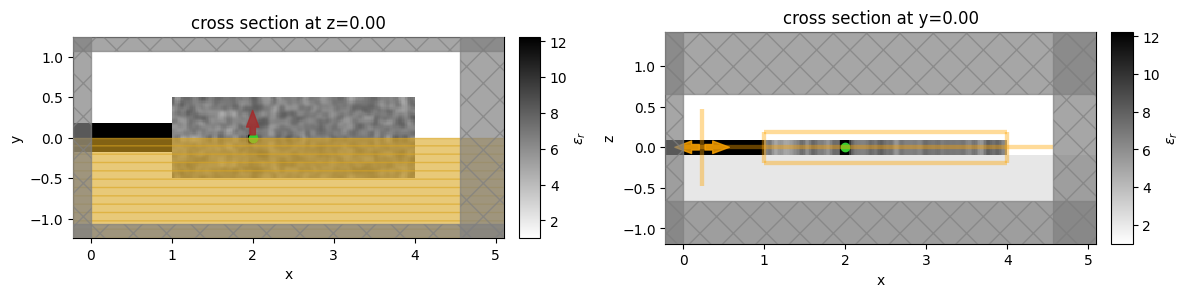

In [9]:
init_par = np.random.uniform(0, 1, (nx_grid, ny_grid))
init_par = sp.ndimage.gaussian_filter(init_par, 1)
init_design = make_adjoint_sim(init_par, beta=beta_min, unfold=True)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
init_design.plot_eps(z=0, ax=ax1, monitor_alpha=0.0)
init_design.plot_eps(y=0, ax=ax2)
plt.show()

We will also look at the collection waveguide mode to ensure we have considered the correct one in the `ModeMonitor` setup. We use the `ModeSolver` plugin to calculate the first two waveguide modes, as below.

In [10]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

sim_init = init_design.to_simulation()[0].copy(
    update=dict(monitors=[field_monitor_xy, mode_monitor] + field_monitor)
)

mode_solver = ModeSolver(
    simulation=sim_init,
    plane=wg_mode_plan,
    mode_spec=td.ModeSpec(num_modes=2),
    freqs=[freq],
)
modes = run_mode_solver(mode_solver)

18:35:06 PST WARNING: The associated `Simulation` object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             `Simulation` object use `reduce_simulation=False`. Setting         
             `reduce_simulation=True` will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-62944899-6562-4dee-993a-b39237800ffc',               
             solver_id='mo-704a12be-56ee-4dab-aa50-67ed38e047e0'.

Output()

Output()

18:35:08 PST Mode solver status: queued

18:35:20 PST Mode solver status: running

18:35:30 PST Mode solver status: success

Output()

After inspecting the mode field distribution, we can confirm that the fundamental waveguide mode is mainly oriented in the `y`-direction, thus matching the dipole orientation.

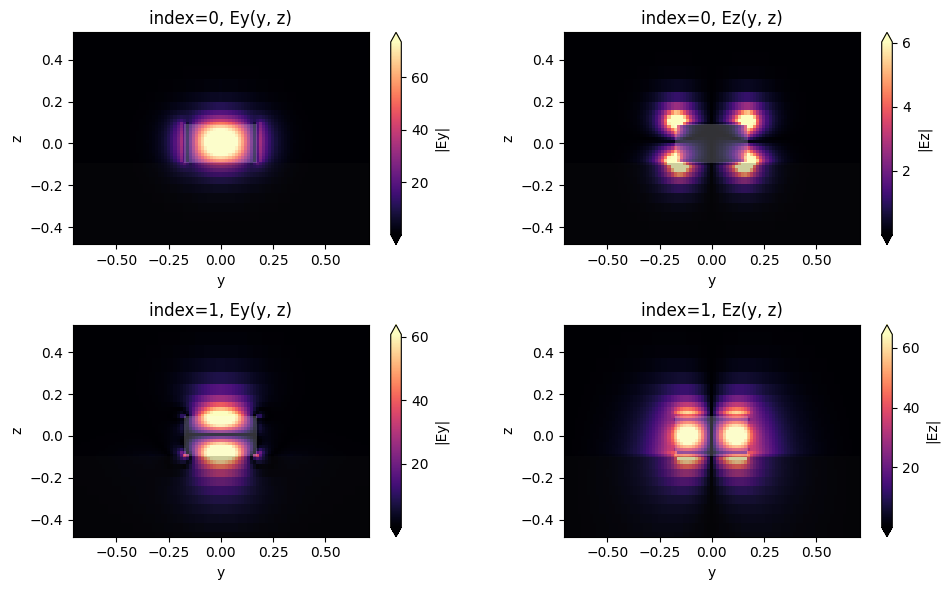

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
for mode_ind in range(2):
    for field_ind, field_name in enumerate(("Ey", "Ez")):
        ax = axs[mode_ind, field_ind]
        mode_solver.plot_field(field_name, "abs", mode_index=mode_ind, f=freq, ax=ax)
        ax.set_title(f"index={mode_ind}, {field_name}(y, z)")

Then, we will calculate the initial coupling efficiency to see how this random structure performs.

In [12]:
sim_data = web.run(sim_init, task_name="initial QE light extractor")

18:35:32 PST Created task 'initial QE light extractor' with task_id             
             'fdve-7775a1b2-e1bc-434c-befc-ad143884b71e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=447434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=234903;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\taskId]8;;\]8;id=447434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\=]8;;\]8;id=423802;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\fdve]8;;\]8;id=447434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\-7775a1b2-e1b]8;;\
             ]8;id=447434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\c-434c-befc-ad143884b71e']8;;\.

Output()

18:35:34 PST status = queued

Output()

18:35:40 PST status = preprocess

18:35:42 PST Maximum FlexCredit cost: 0.061. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:35:59 PST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

18:36:21 PST status = success

             View simulation result at                                          
             ]8;id=905662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=583690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\taskId]8;;\]8;id=905662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\=]8;;\]8;id=485653;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\fdve]8;;\]8;id=905662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\-7775a1b2-e1b]8;;\
             ]8;id=905662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7775a1b2-e1bc-434c-befc-ad143884b71e\c-434c-befc-ad143884b71e']8;;\.

Output()

18:36:25 PST loading simulation from simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

The modal coupling efficiency is normalized by the dipole power. That is necessary because the dipole power will likely change significantly when the optimization algorithm modifies the design region.

18:36:26 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

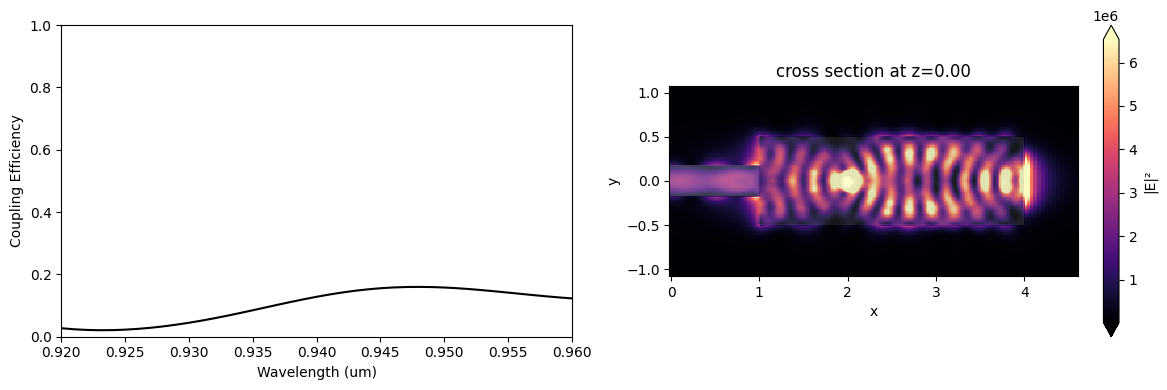

In [13]:
mode_amps = sim_data["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)

coup_eff = mode_power / dip_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
sim_data.plot_field("field_xy", "E", "abs^2", z=0, ax=ax2)
plt.show()

## Optimization
The objective function defined next is the device figure-of-merit (FOM) minus a fabrication penalty. In our optimization strategy, we included a penalty threshold parameter so that the fabrication penalty is included only after some initial iterations defined by `pen_thr`.

In [14]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: tda.JaxSimulationData) -> float:
    """Return the coupling efficiency."""
    mode_amps = sim_data.output_data[0].amps.sel(direction="-", f=freq, mode_index=0)
    mode_power = jnp.sum(jnp.abs(mode_amps) ** 2)
    dip_power = 0
    for m in range(1, 7):
        field_mon = sim_data.output_data[m]
        dip_power += jnp.abs(field_mon.flux)
    return mode_power, dip_power

def penalty(params, beta, delta_eps=0.49):
    params = pre_process(params, beta=beta)
    dilate_fn = lambda x: filter_project(x, beta=100, eta=0.5 - delta_eps)
    eroded_fn = lambda x: filter_project(x, beta=100, eta=0.5 + delta_eps)

    params_dilate_erode = eroded_fn(dilate_fn(params))
    params_erode_dilate = dilate_fn(eroded_fn(params))
    diff = params_dilate_erode - params_erode_dilate
    return jnp.linalg.norm(diff) / jnp.linalg.norm(jnp.ones_like(diff))

# Objective function to be passed to the optimization algorithm.
def obj(param, beta: float = 1.0, step_num: int = None, verbose: bool = False) -> float:
    sim = make_adjoint_sim(param, beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    mode_power, dip_power = fom(sim_data)
    fom_val = mode_power / dip_power
    penalty_weight = 0.1
    penalty_val = penalty(param, beta)
    J = fom_val - penalty_weight * penalty_val
    return J, [sim_data, mode_power, dip_power, penalty_val]

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj, has_aux=True)

In the following cell, we define some functions to save the optimization progress and load a previous optimization from the file.

In [15]:
# where to store history
history_fname = "./misc/qe_coupler.pkl"

def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history_dict, file)

def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history_dict = pickle.load(file)
    return history_dict

Then, we will start a new optimization or load the parameters of a previous one.

In [16]:
# initialize adam optimizer with starting parameters
optimizer = optax.adam(learning_rate=learning_rate)

try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    opt_state = optimizer.init(params)    
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(
        f"Found {num_iters_completed} iterations previously completed out of {max_iter} total."
    )
    if num_iters_completed < max_iter:
        print(f"Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    params = np.array(init_par)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        coupl_eff=[],
        penalty=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
        data=[],
        beta=[],
    )

In the optimization loop, we will gradually increase the projection parameter `beta` to eliminate intermediary permittivity values. At each iteration, we record the design parameters and the optimization history to restore them as needed.

In [17]:
iter_done = len(history_dict["values"])

if iter_done < max_iter:
    for i in range(iter_done, max_iter):
        print(f"Iteration = ({i + 1} / {max_iter})")

        # Compute gradient and current objective function value.
        beta_i = i//iter_steps + beta_min
        (value, data), gradient = obj_grad(params, beta=beta_i, step_num=(i + 1))
        sim_data_i, mode_power_i, dip_power_i, penalty_val_i = data
        # Outputs.
        print(f"\tbeta = {beta_i}")
        print(f"\tJ = {value:.4e}")
        print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")
        print(f"\tpenalty = {penalty_val_i:.3f}")
        print(f"\tmode power = {mode_power_i:.3f}")
        print(f"\tdip power = {dip_power_i:.3f}")
        print(f"\tcoupling efficiency = {mode_power_i/dip_power_i:.3f}")

        # Compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn).
        updates, opt_state = optimizer.update(-gradient, opt_state, params)
        params = optax.apply_updates(params, updates)

        # Cap parameters between 0 and 1.
        params = jnp.minimum(params, 1.0)
        params = jnp.maximum(params, 0.0)

        # Save history.
        history_dict["values"].append(value)
        history_dict["coupl_eff"].append(mode_power_i / dip_power_i)
        history_dict["penalty"].append(penalty_val_i)
        history_dict["params"].append(params)
        history_dict["beta"].append(beta_i)
        history_dict["gradients"].append(gradient)
        history_dict["opt_states"].append(opt_state)
        #history_dict["data"].append(sim_data_i)  # Uncomment to store data, can create large files.
        save_history(history_dict)

Iteration = (1 / 100)


18:36:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:37:13 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:37:16 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 1.0
	J = 2.5337e-02
	grad_norm = 9.6841e-02
	penalty = 1.000
	mode power = 316.879
	dip power = 2528.208
	coupling efficiency = 0.125
Iteration = (2 / 100)


18:38:28 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:38:43 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:38:45 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 1.0
	J = -3.1682e-02
	grad_norm = 5.7021e-02
	penalty = 1.000
	mode power = 279.225
	dip power = 4087.153
	coupling efficiency = 0.068
Iteration = (3 / 100)


18:39:49 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:40:04 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:40:06 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 1.0
	J = 2.1499e-01
	grad_norm = 1.1940e-01
	penalty = 1.000
	mode power = 1066.028
	dip power = 3384.349
	coupling efficiency = 0.315
Iteration = (4 / 100)


18:41:13 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:41:28 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:41:30 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 1.0
	J = 6.5515e-01
	grad_norm = 1.4483e-01
	penalty = 1.000
	mode power = 4286.805
	dip power = 5676.774
	coupling efficiency = 0.755
Iteration = (5 / 100)


18:42:38 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:42:53 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:42:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 1.0
	J = 7.6215e-01
	grad_norm = 2.3398e-01
	penalty = 1.000
	mode power = 6240.459
	dip power = 7238.237
	coupling efficiency = 0.862
Iteration = (6 / 100)


18:43:58 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:44:13 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:44:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 2.0
	J = 7.5999e-01
	grad_norm = 2.0300e-01
	penalty = 0.993
	mode power = 12687.451
	dip power = 14765.021
	coupling efficiency = 0.859
Iteration = (7 / 100)


18:45:19 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:45:34 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:45:36 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 2.0
	J = 5.9722e-01
	grad_norm = 4.8408e-01
	penalty = 0.987
	mode power = 6054.042
	dip power = 8699.054
	coupling efficiency = 0.696
Iteration = (8 / 100)


18:46:34 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:46:35 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:46:50 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:46:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 2.0
	J = 6.8212e-01
	grad_norm = 6.5644e-01
	penalty = 0.982
	mode power = 16409.463
	dip power = 21028.164
	coupling efficiency = 0.780
Iteration = (9 / 100)


18:47:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:48:10 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:48:12 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 2.0
	J = 8.1074e-01
	grad_norm = 6.4563e-01
	penalty = 0.977
	mode power = 10490.750
	dip power = 11548.682
	coupling efficiency = 0.908
Iteration = (10 / 100)


18:49:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:49:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:49:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 2.0
	J = 8.1854e-01
	grad_norm = 6.1785e-01
	penalty = 0.972
	mode power = 9519.038
	dip power = 10394.820
	coupling efficiency = 0.916
Iteration = (11 / 100)


18:50:41 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:50:57 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:50:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 3.0
	J = 8.2363e-01
	grad_norm = 6.4004e-01
	penalty = 0.938
	mode power = 14645.064
	dip power = 15962.413
	coupling efficiency = 0.917
Iteration = (12 / 100)


18:51:58 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:52:14 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:52:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 3.0
	J = 7.3747e-01
	grad_norm = 6.2776e-01
	penalty = 0.930
	mode power = 22439.867
	dip power = 27020.139
	coupling efficiency = 0.830
Iteration = (13 / 100)


18:53:30 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:53:45 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:53:47 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 3.0
	J = 6.8650e-01
	grad_norm = 7.4500e-01
	penalty = 0.921
	mode power = 13291.670
	dip power = 17070.334
	coupling efficiency = 0.779
Iteration = (14 / 100)


18:54:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:55:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:55:16 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 3.0
	J = 7.3383e-01
	grad_norm = 7.2693e-01
	penalty = 0.913
	mode power = 23227.283
	dip power = 28150.951
	coupling efficiency = 0.825
Iteration = (15 / 100)


18:56:20 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:56:35 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:56:37 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 3.0
	J = 8.0620e-01
	grad_norm = 6.0494e-01
	penalty = 0.905
	mode power = 30429.607
	dip power = 33934.188
	coupling efficiency = 0.897
Iteration = (16 / 100)


18:57:51 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:58:06 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:58:08 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 4.0
	J = 8.2800e-01
	grad_norm = 7.7410e-01
	penalty = 0.844
	mode power = 17605.803
	dip power = 19296.205
	coupling efficiency = 0.912
Iteration = (17 / 100)


18:59:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:59:38 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

18:59:40 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 4.0
	J = 8.1808e-01
	grad_norm = 8.3984e-01
	penalty = 0.838
	mode power = 27747.586
	dip power = 30767.631
	coupling efficiency = 0.902
Iteration = (18 / 100)


19:01:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:01:36 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:01:38 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 4.0
	J = 7.5400e-01
	grad_norm = 7.9776e-01
	penalty = 0.831
	mode power = 36156.789
	dip power = 43193.449
	coupling efficiency = 0.837
Iteration = (19 / 100)


19:02:43 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:02:44 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:02:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:03:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 4.0
	J = 7.2394e-01
	grad_norm = 1.0621e+00
	penalty = 0.824
	mode power = 27301.365
	dip power = 33859.844
	coupling efficiency = 0.806
Iteration = (20 / 100)


19:04:04 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:04:05 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:04:20 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:04:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 4.0
	J = 7.6467e-01
	grad_norm = 4.0206e-01
	penalty = 0.817
	mode power = 57812.738
	dip power = 68306.906
	coupling efficiency = 0.846
Iteration = (21 / 100)


19:05:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:05:42 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:05:44 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 5.0
	J = 8.1064e-01
	grad_norm = 1.3085e+00
	penalty = 0.745
	mode power = 22579.400
	dip power = 25509.314
	coupling efficiency = 0.885
Iteration = (22 / 100)


19:06:58 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:06:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:07:14 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:07:15 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 5.0
	J = 7.9859e-01
	grad_norm = 1.5160e+00
	penalty = 0.739
	mode power = 33636.875
	dip power = 38554.535
	coupling efficiency = 0.872
Iteration = (23 / 100)


19:08:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:08:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:08:50 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 5.0
	J = 7.1812e-01
	grad_norm = 1.4755e+00
	penalty = 0.733
	mode power = 40364.430
	dip power = 50999.652
	coupling efficiency = 0.791
Iteration = (24 / 100)


19:10:10 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:10:26 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:10:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 5.0
	J = 7.2169e-01
	grad_norm = 1.4796e+00
	penalty = 0.727
	mode power = 36059.465
	dip power = 45395.074
	coupling efficiency = 0.794
Iteration = (25 / 100)


19:11:44 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:11:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:12:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 5.0
	J = 7.8996e-01
	grad_norm = 7.2305e-01
	penalty = 0.719
	mode power = 78312.578
	dip power = 90868.180
	coupling efficiency = 0.862
Iteration = (26 / 100)


19:13:06 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:13:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:13:23 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 6.0
	J = 8.1052e-01
	grad_norm = 1.6643e+00
	penalty = 0.640
	mode power = 45615.199
	dip power = 52158.055
	coupling efficiency = 0.875
Iteration = (27 / 100)


19:15:11 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:15:26 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:15:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 6.0
	J = 7.7825e-01
	grad_norm = 4.6208e-01
	penalty = 0.638
	mode power = 89221.805
	dip power = 105957.734
	coupling efficiency = 0.842
Iteration = (28 / 100)


19:16:47 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:17:02 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:17:03 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 6.0
	J = 7.5289e-01
	grad_norm = 1.7900e+00
	penalty = 0.635
	mode power = 58701.230
	dip power = 71898.781
	coupling efficiency = 0.816
Iteration = (29 / 100)


19:18:20 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:18:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:18:36 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:18:37 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 6.0
	J = 7.9447e-01
	grad_norm = 1.5349e+00
	penalty = 0.628
	mode power = 99654.953
	dip power = 116245.344
	coupling efficiency = 0.857
Iteration = (30 / 100)


19:19:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:20:10 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:20:11 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 6.0
	J = 7.7494e-01
	grad_norm = 3.5299e-01
	penalty = 0.626
	mode power = 130813.898
	dip power = 156181.281
	coupling efficiency = 0.838
Iteration = (31 / 100)


19:21:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:21:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:21:50 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 7.0
	J = 7.5792e-01
	grad_norm = 6.2651e-01
	penalty = 0.570
	mode power = 164167.109
	dip power = 201452.406
	coupling efficiency = 0.815
Iteration = (32 / 100)


19:23:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:23:39 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:23:41 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

	beta = 7.0
	J = 7.0591e-01
	grad_norm = 3.3179e+00
	penalty = 0.574
	mode power = 75816.648
	dip power = 99329.953
	coupling efficiency = 0.763
Iteration = (33 / 100)


19:25:19 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:25:35 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

19:25:36 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

KeyboardInterrupt: 

Ultimately, we get all the information to assess the optimization results.

In [18]:
obj_vals = np.array(history_dict["values"])
ce_vals = np.array(history_dict["coupl_eff"])
pen_vals = np.array(history_dict["penalty"])
final_par_density = history_dict["params"][-1]
final_beta = history_dict["beta"][-1]

### Results
The following figure shows how coupling efficiency and the fabrication penalty have evolved along the optimization process. The coupling efficiency quickly rises above 0.8, and along the binarization process, we can observe two large drops before a more stable final optimization stage. The formation of resonant modes sensitive to the small structural changes can potentially explain this behavior. The discontinuities in the fabrication penalty curve are caused by the increments in the projection parameter beta at each 5 iterations.

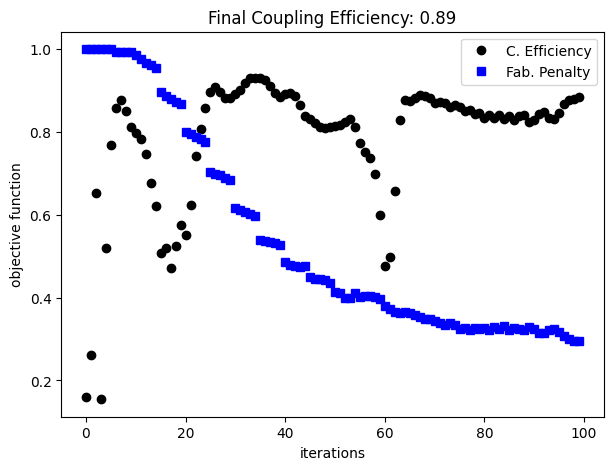

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(ce_vals, "ko", label="C. Efficiency")
ax.plot(pen_vals, "bs", label="Fab. Penalty")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final Coupling Efficiency: {ce_vals[-1]:.2f}")
ax.legend()
plt.show()

Interestingly, the final quantum emitter light extractor resembles a nanocavity, even though we have considered only the coupling efficiency into the output waveguide in the optimization. We have DBR mirrors on both sides of the dipole. However, on the left side, the mirror has only a few periods and partially reflects the radiation, which couples to the output waveguide.

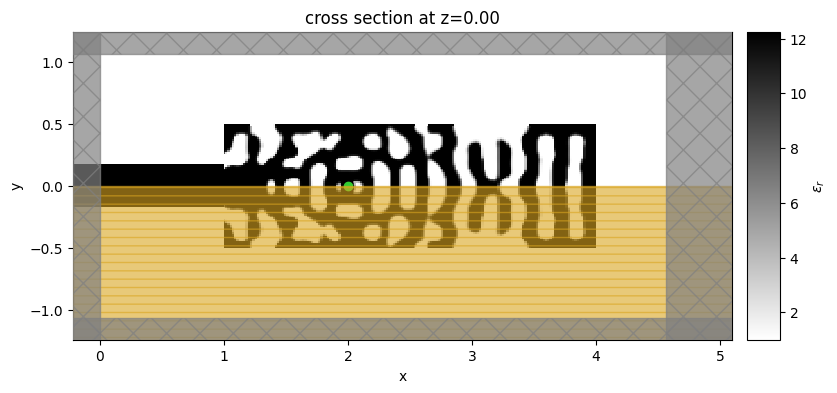

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 4))
sim_final = make_adjoint_sim(final_par_density, beta=final_beta, unfold=True)
sim_final = sim_final.to_simulation()[0].copy(
    update=dict(monitors=[field_monitor_xy, mode_monitor] + field_monitor)
)
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax)
plt.show()

To better understand the resultant design, let's simulate the final structure to obtain its spectral response and field distribution.

In [21]:
sim_data_final = web.run(sim_final, task_name="final QE light extractor")

12:28:38 -03 Created task 'final QE light extractor' with task_id               
             'fdve-318f5226-2e2b-4aa5-810c-162e67b7c979' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=695443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=342432;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\taskId]8;;\]8;id=695443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\=]8;;\]8;id=464612;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\fdve]8;;\]8;id=695443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\-318f5226-2e2]8;;\
             ]8;id=695443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\b-4aa5-810c-162e67b7c979']8;;\.

Output()

12:28:42 -03 status = queued

Output()

12:28:46 -03 status = preprocess

12:28:53 -03 Maximum FlexCredit cost: 0.061. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:29:21 -03 early shutoff detected at 48%, exiting.

             status = postprocess

Output()

12:29:34 -03 status = success

             View simulation result at                                          
             ]8;id=253674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=625047;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\taskId]8;;\]8;id=253674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\=]8;;\]8;id=313416;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\fdve]8;;\]8;id=253674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\-318f5226-2e2]8;;\
             ]8;id=253674;https://tidy3d.simulation.cloud/workbench?taskId=fdve-318f5226-2e2b-4aa5-810c-162e67b7c979\b-4aa5-810c-162e67b7c979']8;;\.

Output()

12:29:42 -03 loading simulation from simulation_data.hdf5

In this cavity-like system, the extraction efficiency of photons from the QE into the collection waveguide mode is proportional to $\beta\times C_{wg}$, where the $\beta$-factor quantifies the fraction of the QE spontaneous emission emitted in the cavity mode, and $C_{wg}$ is the fraction of the cavity photons coupled to the guided mode `A. Enderlin, Y. Ota, R. Ohta, N. Kumagai, S. Ishida, S. Iwamoto, and Y. Arakawa, "High guided mode–cavity mode coupling for an efficient extraction of spontaneous emission of a single quantum dot embedded in a photonic crystal nanobeam cavity," Phys. Rev. B 86, 075314 (2012)` [DOI: 10.1103/PhysRevB.86.075314](https://link.aps.org/doi/10.1103/PhysRevB.86.075314). By the field distribution image below, we can see a cavity mode resonance, which should increase the Purcell factor at the QE position, thus contributing to a higher $\beta$-factor. At the same time, the partial reflection mirror at the left side was potentially optimized to adjust $C_{wg}$.

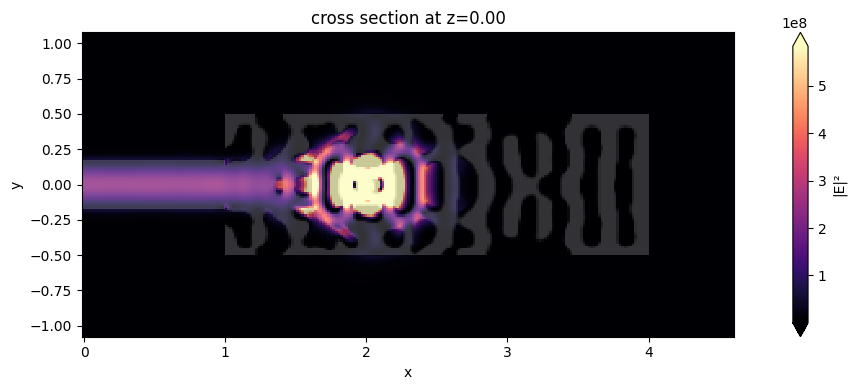

In [22]:
f, ax1 = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)
sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax1)
plt.show()

To conclude, we will calculate the final coupling efficiency and the cavity Purcell value. The coupling efficiency is above 80% along an extensive wavelength range, and we have confirmed the Purcell enhancement.

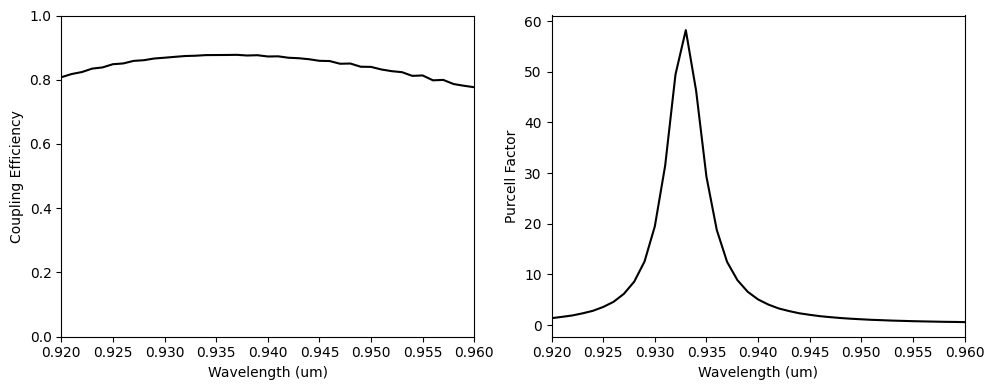

In [23]:
# Coupling efficiency.
mode_amps = sim_data_final["mode_monitor"].amps.sel(direction="-", mode_index=0)
mode_power = np.abs(mode_amps) ** 2
dip_power = np.zeros(n_wl)
for i in range(len(field_monitor)):
    field_mon = sim_data_final[f"field_monitor_{i}"]
    dip_power += np.abs(field_mon.flux)
coup_eff = mode_power / dip_power

# Purcell factor.
bulk_power = ((2 * np.pi * freqs) ** 2 / (12 * np.pi)) * (td.MU_0 * n_wg / td.C_0)
bulk_power = bulk_power * 2 ** (2 * np.sum(np.abs(sim_final.symmetry)))
purcell = dip_power / bulk_power

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_ylim(0, 1)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
ax2.plot(wl_range, purcell, "-k")
ax2.set_xlabel("Wavelength (um)")
ax2.set_ylabel("Purcell Factor")
ax2.set_xlim(wl - bw / 2, wl + bw / 2)
plt.show()

## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [24]:
sim_final.to_gds_file(
    fname="./misc/inv_des_light_extractor.gds",
    z=0,
    permittivity_threshold=(eps_max + eps_min) / 2,
    frequency=freq,
)